## Import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


from torchvision import transforms

In [8]:
import pandas as pd
import numpy as np

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Preview

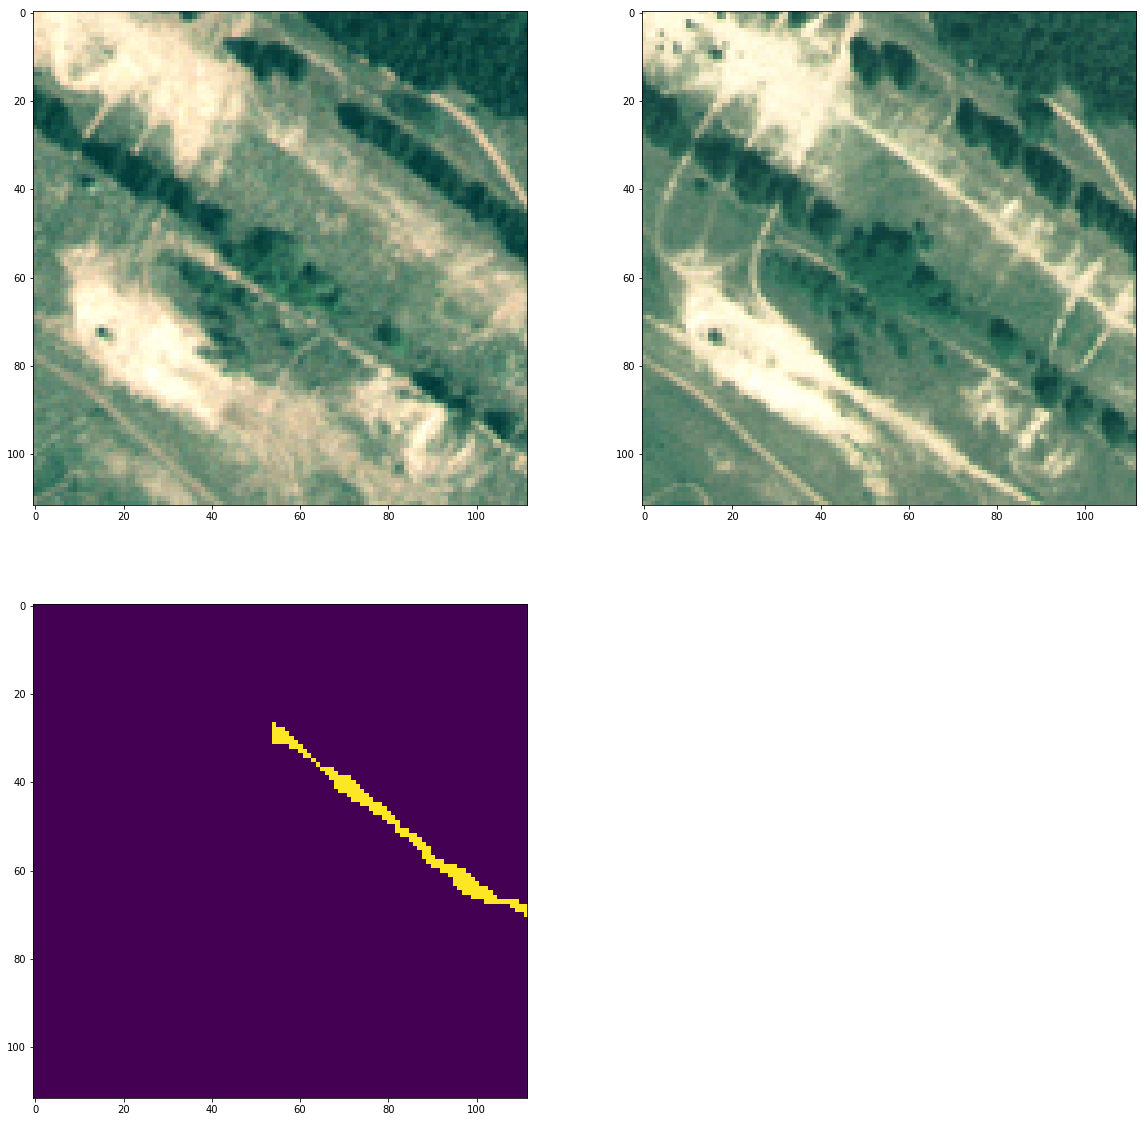

In [3]:
img1_path = 'datasets/train/Szada_Scene1_img1_Clip4_View0.png'
img2_path = 'datasets/train/Szada_Scene1_img2_Clip4_View0.png'
gt_path = 'datasets/trainGT/Szada_Scene1_gt_Clip4_View0.png'

img1 = mpimg.imread(img1_path)
img2 = mpimg.imread(img2_path)
gt = mpimg.imread(gt_path)

plt.figure(figsize=(20,20))

plt.subplot(221)
plt.imshow(img1)
plt.subplot(222)
plt.imshow(img2)
plt.subplot(223)
plt.imshow(gt)

plt.show()

## Input

In [4]:
data_transforms = transforms.Compose([
    transforms.ToTensor() # 转化为Tensor
])

x1 = data_transforms(img1)
x2 = data_transforms(img2)

## Model

In [5]:
class SiameseNet(nn.Module):
    def __init__(self):
        super(SiameseNet, self).__init__()
        self.featureExtract = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.Conv2d(64, 64, 5, padding=2),
            nn.Conv2d(64, 32, 5, padding=2),
            nn.Conv2d(32, 16, 1, padding=0),
        )
        

    def forward(self,x1,x2):
        x1 = self.featureExtract(x1)
        x2 = self.featureExtract(x2)        
        x = F.pairwise_distance(x1,x2,p=2)
        
        return x

## Output

In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = "cpu"
model = SiameseNet().to(device)
y = model(x1.view([-1]+list(x1.shape)),x2.view([-1]+list(x2.shape)))

In [7]:
def showTensor(x):
    deTransforms = transforms.Compose([
        transforms.ToPILImage()
    ])
    
    x = deTransforms(x)
#     plt.imshow(x)
    
    return x

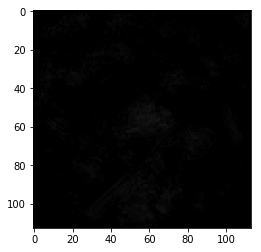

In [8]:
z = F.relu(y-y.mean())



z = showTensor(z)
plt.imshow(z,cmap='gray')

In [83]:
data = pd.read_csv('./data.csv')
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
data.shape[0]

3888

In [5]:
# %load train.py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import os

from configs import Config
from models import SiameseNet
from data_loader import myData


# configuration
cf = Config()
batch_size = cf.batch_size
num_epochs = cf.num_epochs
num_workers = cf.num_workers
leaning_rate = cf.learning_rate
momentum = cf.momentum
weight_decay = cf.weight_decay

# dataset
data_transforms = transforms.Compose([
    transforms.ToTensor(),
])

trainSet = myData(dataPath='./train.csv',
                  transform=data_transforms)
testSet = myData(dataPath='./test.csv',
                 transform=data_transforms)

trainLoader = DataLoader(dataset=trainSet,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=num_workers)
testLoader = DataLoader(dataset=testSet,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=num_workers)

# net
net = SiameseNet()
# gpu
if cf.use_gpu:
    net.to('cuda')

net.train()

# optimizer
# optimizer = optim.Adam(net.parameters(),lr=leaning_rate)
optimizer = optim.SGD(net.parameters(), lr=leaning_rate,
                      momentum=momentum, weight_decay=weight_decay)
optimizer.zero_grad()



In [ ]:
net.